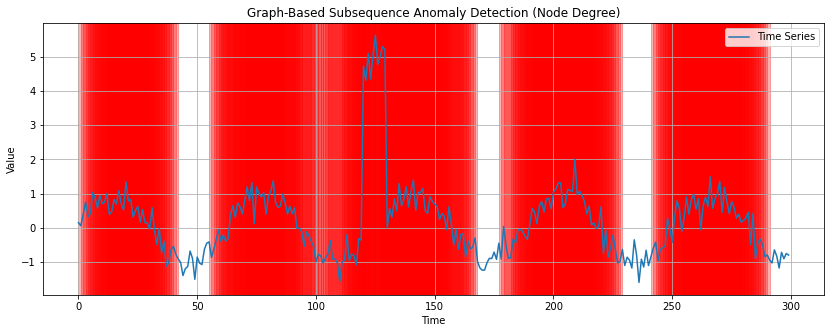

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# 1. Generate time series with anomaly
np.random.seed(42)
n = 300
t = np.linspace(0, 30, n)
ts = np.sin(t) + 0.3 * np.random.randn(n)
ts[120:130] += 5  # Inject spike anomaly

# 2. Extract subsequences using sliding window
def extract_subsequences(ts, window_size=20, stride=1):
    subsequences = []
    indices = []
    for i in range(0, len(ts) - window_size + 1, stride):
        subsequences.append(ts[i:i + window_size])
        indices.append(i)
    return np.array(subsequences), np.array(indices)

window_size = 20
stride = 1
subseqs, start_indices = extract_subsequences(ts, window_size, stride)

# 3. Normalize subsequences and compute similarity matrix
scaler = StandardScaler()
subseqs_scaled = scaler.fit_transform(subseqs)
sim_matrix = cosine_similarity(subseqs_scaled)

# 4. Build similarity graph (nodes = subsequences, edges = high similarity)
threshold = 0.9
G = nx.Graph()
num_nodes = len(subseqs)
G.add_nodes_from(range(num_nodes))

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        sim = sim_matrix[i, j]
        if sim > threshold:
            G.add_edge(i, j, weight=sim)

# 5. Detect anomalies based on node degree (low degree = isolated = anomaly)
node_degrees = np.array([G.degree(n) for n in G.nodes()])
degree_threshold = np.percentile(node_degrees, 10)  # bottom 10% = anomaly
anomaly_nodes = [n for n, deg in enumerate(node_degrees) if deg <= degree_threshold]
anomaly_indices = start_indices[anomaly_nodes]

# 6. Plot time series with detected anomalous subsequences
plt.figure(figsize=(14, 5))
plt.plot(ts, label='Time Series')
for idx in anomaly_indices:
    plt.axvspan(idx, idx + window_size, color='red', alpha=0.3)
plt.title("Graph-Based Subsequence Anomaly Detection (Node Degree)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tslearn.metrics import dtw
from sklearn.preprocessing import StandardScaler

# 1. Generate time series with anomaly
np.random.seed(42)
n = 300
t = np.linspace(0, 30, n)
ts = np.sin(t) + 0.3 * np.random.randn(n)
ts[120:130] += 5  # Inject spike anomaly

# 2. Extract subsequences using sliding window (21-day window)
def extract_subsequences(ts, window_size=21, stride=1):
    subsequences = []
    indices = []
    for i in range(0, len(ts) - window_size + 1, stride):
        subsequences.append(ts[i:i + window_size])
        indices.append(i)
    return np.array(subsequences), np.array(indices)

window_size = 21
stride = 1
subseqs, start_indices = extract_subsequences(ts, window_size, stride)

# 3. Normalize each subsequence
scaler = StandardScaler()
subseqs_scaled = scaler.fit_transform(subseqs)

# 4. Build graph using DTW similarity (lower distance = more similar)
threshold = 2.5  # Adjust this based on your data
G = nx.Graph()
num_nodes = len(subseqs_scaled)
G.add_nodes_from(range(num_nodes))

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        dist = dtw(subseqs_scaled[i], subseqs_scaled[j])
        if dist < threshold:
            G.add_edge(i, j, weight=dist)

# 5. Detect anomalies using node degree (low degree = anomaly)
node_degrees = np.array([G.degree(n) for n in G.nodes()])
degree_threshold = np.percentile(node_degrees, 10)  # bottom 10% = anomaly
anomaly_nodes = [n for n, deg in enumerate(node_degrees) if deg <= degree_threshold]
anomaly_indices = start_indices[anomaly_nodes]

# 6. Plot results
plt.figure(figsize=(14, 5))
plt.plot(ts, label='Time Series')
for idx in anomaly_indices:
    plt.axvspan(idx, idx + window_size, color='red', alpha=0.3)
plt.title("Graph-Based Time Series Anomaly Detection using DTW (21-Day Window)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


SystemError: initialization of _internal failed without raising an exception